In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#set warning to ignore
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from random import sample,choice
from math import sqrt,ceil

import logging

from sklearn.metrics import accuracy_score

# Decision Tree

In [38]:
GINI = "gini"
ENTROPY = "entropy"

####Definisco le classi DecisionTree, Question, Leaf, Node
class DecisionTree: 
    
    def __init__(self,
                 question=None,
                 true_branch=None,
                 false_branch=None,
                 metrics=None, 
                 max_depth=None,
                 leafs=None,
                 final_leaf=None,
                 final_depth=None):
        
        self.question = question #è il nodo dell'albero, in cui sono salvate le info sulla feature e relativa soglia di split -> vedi classi Question()
        self.true_branch = true_branch
        self.false_branch = false_branch
        self.max_depth = max_depth #profondita albero
        self.leafs = [] #foglie dell'albero (ovvero i nodi finali)
        self.final_leaf = final_leaf
        self.final_depth = final_depth
        
        if metrics is None:
            self.metrics = GINI  
        else:
            self.metrics = metrics  
   
              
        
    def build_tree(self,train_data,header,count=0):
        
        """Builds the tree.
        Try partitioning the dataset on each of the unique attribute,
        calculate the information gain,
        and return the question that produces the highest gain.
        """
        if count == 0: logging.debug('----NODE 0----')
        
        #inizio dell'algoritmo, questa funzione a partire dal dataset iniziale trovo la migliore feature e punto di split per ogni iterazione
        gain, question = self.find_best_split(train_data, header)
            
        if isinstance(train_data,pd.DataFrame):
            train_data = train_data.values.tolist()
        
        # Base case: no further info gain
        # Since we can ask no further questions,
        # we'll return a leaf.
        if gain < 0.001:
            logging.debug("final gain: ",gain)
            logging.debug("final depth: ",count)
            leafs = self.leafs.append(Leaf(train_data))
            #logging.debug(leafs)
            return DecisionTree(None,
                                self.true_branch, 
                                self.false_branch,
                                self.metrics,
                                self.max_depth,
                                leafs,
                                Leaf(train_data),count)
        
        # Base case: we reached the max depth of the tree
        # we'll return a leaf.
        if count == self.max_depth:
            logging.debug("final gain: ",gain)
            logging.debug("final depth: ",count)
            self.leafs.append(Leaf(train_data))
            
            return DecisionTree(None,
                                self.true_branch, 
                                self.false_branch,
                                self.metrics,
                                self.max_depth,
                                self.leafs,
                                Leaf(train_data),count)

        
        logging.debug("best question is ''{}'' with information gain: {}".format(question,round(gain,2)))
        logging.debug("depth: ",count)
        logging.debug("gain: ",gain)
        
        #divide il dataset in due parti utilizzando la feature e la soglia trovati
        true_rows, false_rows = partition(train_data, question)
        
        # Recursively build the true branch.
        logging.debug("\n----TRUE BRANCH----")
        true_branch = self.build_tree(true_rows,header,count+1)
        
        # Recursively build the false branch.
        logging.debug("\n----FALSE BRANCH----")
        false_branch = self.build_tree(false_rows,header,count+1)
        
        return DecisionTree(question,
                            true_branch, 
                            false_branch,
                            self.metrics,
                            self.max_depth,
                            self.leafs,
                            None,count)
    
    def initialize_split(self,train_data):
        
        if self.metrics == GINI:
            # Calculate the information gain from this split
            current_uncertainty = gini(train_data)
               
        if self.metrics == ENTROPY:
            
            current_uncertainty = entropy(train_data)
        
        return current_uncertainty
     
    def find_best_split(self,train_data,header):
        """Find the best question to ask by iterating over every feature / value
        and calculating the information gain."""
    
        if isinstance(train_data,pd.DataFrame):
            train_data = train_data.values.tolist()
        
        n_features = len(train_data[0]) - 1  # number of columns
        
        best_gain = 0  # keep track of the best information gain
        best_question = None  # keep train of the feature / value that produced it
        current_uncertainty = self.initialize_split(train_data)
        
        for col in range(n_features):  # for each feature
            
            values = unique_vals(train_data, col)  # unique values in the column
            # logging.debug("Valori presi in considerazione da find_best_split")
            # logging.debug("---------------------------------------------------")
            # logging.debug("values features n° {} ''{}'': {}".format(col+1,header[col],values))
            # logging.debug("---------------------------------------------------")
            for val in values:  # for each value
        
                question = Question(header, col, val)
                
                # try splitting the dataset
                true_rows, false_rows = partition(train_data, question)
                
                # Skip this split if it doesn't divide the dataset.
                if len(true_rows) == 1 or len(false_rows) == 1:
                    continue
                
                # Calculate the information gain from this split
                gain = info_gain(self.metrics, true_rows, false_rows, current_uncertainty)
               
                if gain >= best_gain:
                    best_gain, best_question = gain, question
    
        return best_gain, best_question


    def classify(self,row):
        """See the 'rules of recursion' above."""
        
        # Base case: we've reached a leaf
        if self.true_branch == None or self.true_branch == None:
            logging.debug("predictions: {} ".format(self.final_leaf.predictions))
            return self.final_leaf.predictions
    
        logging.debug("tree_classifier->classify:",self.question)
       
        #logging.debug("input value {}".format(row[node.question.column]))
        
        #logging.debug(self.question.match(row))
        if self.question.match(row):
            logging.debug("yes")
            return self.true_branch.classify(row)
        else:
            logging.debug("no")
            return self.false_branch.classify(row)
    
    
class Question:
    """A Question is used to partition a dataset.

    This class just records a 'column number' (e.g., 0 for Color) and a
    'column value' (e.g., Green). The 'match' method is used to compare
    the feature value in an example to the feature value stored in the
    question. See the demo below.
    """

    def __init__(self,header, column, value):
        self.header = header
        self.column = column
        self.value = value
        

    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this question.
        
        val = example[self.column]
        #logging.debug("valore domanda {}".format(self.value))
        #logging.debug("::input value {}::".format(val))
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

    def __repr__(self):
        # This is just a helper method to logging.debug
        # the question in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (
            self.header[self.column], condition, str(self.value))
 
    
class Leaf:
    """A Leaf node classifies data.

    This holds a dictionary of class (e.g., "Apple") -> number of times
    it appears in the rows from the training data that reach this leaf.
    """

    def __init__(self, rows):
        self.predictions = class_counts(rows)


###### UTILITY FUNCTIONS ######       
def unique_vals(rows, col):
    """Find the unique values for a column in a dataset."""
    return set([row[col] for row in rows])

def class_counts(rows):
    """Counts the number of each type of example in a dataset."""
    counts = {}  # a dictionary of label -> count.
    for row in rows:
        # in our dataset format, the label is always the last column
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

def print_leaf(counts):
    """A nicer way to print the predictions at a leaf."""
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

def is_numeric(value):
    """Test if a value is numeric."""
    return isinstance(value, (int,float))

def partition(rows, question):
    """Partitions a dataset.

    For each row in the dataset, check if it matches the question. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    """
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

########################## decision tree metrics #############################

def gini(rows):
    """Calculate the Gini Impurity for a list of rows.
    p_x = probabilities of find element of "x" class 
    """
    
    classes_count = class_counts(rows)
    impurity = 1
    for x in classes_count: 
        p_x = classes_count[x] / float(len(rows))
        impurity -= p_x**2
    
    return impurity


def entropy(rows):
    """
    Calculate the entropy of a dataset.
    p_x = probabilities of find element of "x" class 
    """
    classes_count = class_counts(rows)
    entropy = 0
    for x in classes_count: 
        p_x = classes_count[x] / float(len(rows))
        entropy-=p_x*np.log2(p_x)

    return entropy

def info_gain(metrics,left, right, current_uncertainty):
    """Information Gain.

    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes.
    """
    p = float(len(left)) / (len(left) + len(right))
    if metrics == GINI:
        # Calculate the information gain from this split
        return current_uncertainty - p * gini(left) - (1 - p) * gini(right)
               
    if metrics == ENTROPY:
        return current_uncertainty - p * entropy(left) - (1 - p) * entropy(right)
    
#given a dictionary return the key with the highest value
def max_key(d):
    max_key = None
    max_value = None
    for key,value in d.items():
        if max_value is None or value > max_value:
            max_key = key
            max_value = value
    return max_key   
       
#calculate accuracy from pandas series
def get_accuracy_score(y_true,y_pred):
    return np.sum(y_true == y_pred)/len(y_true)

# Random Forest

In [39]:
def get_input_var_pos(header,var_tree):
    
    input_variables = []
    for var in var_tree:
        for idx,head in enumerate(header):
            if var == head:
                input_variables.append(idx)
                
    return input_variables

def sub_sample_and_features(df,labels,n_selected_features,sample_ratio = 0.5):
    
    n_features = df.shape[1]-1
    n_row = df.shape[0]

    #estrae un sample degli indici delle righe di dimensione pari a n_row*sample_ratio
    sampled_row = sample(range(0,n_row), round(n_row*float(sample_ratio)))
    
    
    if n_selected_features == "best":
        #estrae un sample delle features di dimensione pari a sqrt(n_features)
        selected_features = sample(range(0,n_features), ceil(sqrt(n_features)))
    elif n_selected_features == "all":
        #estrae un sample delle features di dimensione pari a n_features
        selected_features = sample(range(0,n_features), n_features)
    else:
        #estrae un sample delle features di dimensione pari a n_selected_features
        selected_features = sample(range(0,n_features), n_selected_features)
    
    df_sel = df.iloc[sampled_row,selected_features]
    
    bootstrap_sample = df_sel.join(labels)#.reset_index(drop=True)
    
    out_of_bag_sample = df.drop(df.index[sampled_row])[bootstrap_sample.columns.tolist()]#.reset_index(drop=True)
    
    return bootstrap_sample,out_of_bag_sample

class RandomForest():
    
    '''Random Forest:
       - decision_tree_type: tipologia di albero da utilizzare (con gini o con entropia)
       - n_trees: numero di alberi da utilizzare nella foresta
       - trained_trees: in questa variabile vengono salvati tutti gli alberi della foresta (già addestrati)
    '''    
    
    def __init__(self,decision_tree_type,n_trees,trained_trees=None#,out_of_bag_predictions=[]
                 ):
        self.decision_tree_type = decision_tree_type
        self.n_trees = n_trees
        self.trained_trees = trained_trees
        #self.out_of_bag_predictions = out_of_bag_predictions

    def build_forest(self,train_data_df,sample_ratio,n_selected_features):
        
        random_forest = []
        labels = train_data_df.iloc[:,-1]
        
        for i in range(0,self.n_trees):
            print("::::::::::::::TREE N° {}::::::::::::::".format(i))
            
            #effettuo il sub sampling e la selezione delle features
            #se n_selected_features = "best" allora seleziona la radice quadrata del numero di features
            bootstrap_sample,out_of_bag_sample = sub_sample_and_features(train_data_df,labels,n_selected_features,sample_ratio)
            
            header = bootstrap_sample.columns.values.tolist() #qui salvo le variabili utilizzate dall'albero
            
            trained_tree = self.decision_tree_type.build_tree(bootstrap_sample,header[:-1]) #addestro l'albero i-esimo con il sub sample del training set
            
            print("Variabili utilizzate: {}".format(header[:-1]))
            print("Numero di record utilizzati: {}".format(bootstrap_sample.shape[0]))
            
            '''calcolo degli out of bag predictions'''
            out_of_bag_sample['pred'] = out_of_bag_sample.loc[:,out_of_bag_sample.columns != 'Transported'].apply(lambda x: max_key(trained_tree.classify(x)),axis=1)
            
            out_of_bag_sample = out_of_bag_sample.drop(out_of_bag_sample.columns.difference(['pred','Transported','PassengerId']), 1)
            
            self.out_of_bag_predictions = self.out_of_bag_predictions.append(out_of_bag_sample)
            
            #join all the dataframe in the list out_of_bag_predictions on the column 'PassengerId'
            final_df = reduce(lambda left,right: pd.merge(left,right,on='PassengerId'), self.out_of_bag_predictions)
            
            #for each passengerId, get the most voted prediction
            #final_df_pred = final_df.groupby('PassengerId').agg(lambda x:x.value_counts().index[0])
            
            #print("Accuracy sull'out of bag sample: {}".format(score))
            
            #----------------------
                
            #salva l'albero addestrato nella property trained_trees e relative variabili utilizzate nell'oggetto RandomForest
            random_forest.append([header,trained_tree])
        
        return RandomForest(self.decision_tree_type, self.n_trees, random_forest)
    
    
    def classify_forest(self,data_variables,data):
        
        tree_predictions = Counter()
        
        for j in self.trained_trees:       
            tree = j[1] #seleziono l'albero j-esimo della foresta
            selected_var = data[get_input_var_pos(data_variables,j[0])] #seleziono le variabili utilizzate dall'albero j-esimo
            pred = tree.classify(selected_var) #classifico la riga data con l'albero j-esimo
            for key,value in pred.items():
                tree_predictions[key] += value
        
        final_prediction = tree_predictions.most_common()[0]
        
        #print("Classificato come {} con {} voti".format(final_prediction[0],final_prediction[1]))      
        return final_prediction[0]
        
        
    def get_model_accuracy(self,data_variables,validate_data):
        #TO-DO
        labels = validate_data.iloc[:,-1].values
        
        predictions = []
        for i,row in enumerate(validate_data.values):            
            pred = self.classify_forest(data_variables,row)
            predictions.append(pred)
            #print("Y_pred= {}; Y= {}".format(pred,labels[i]))
        
        predictions = np.array(predictions)
        print()
        if len(labels) == len(predictions):
                
            if is_numeric(predictions) and is_numeric(labels[0]):
                
                E_SS = np.sum((predictions - labels.mean()) ** 2)
                T_SS = np.sum((labels - labels.mean())** 2)
                print("Accuratezza modello del {}".format(E_SS/T_SS))
            
            else:
                
                acc = [1 if x == y else 0  for x, y in zip(labels, predictions)]
                acc_tot = sum(acc)/len(labels) * 100
                print("Accuratezza modello del {}".format(acc_tot))
                
        return predictions   

In [40]:
#bootstrap_sample,out_of_bag_sample=sub_sample_and_features(space_titanic_df, space_titanic_df.iloc[:,-1],2,0.8)

# Import dei dataset e cleaning dei dati

In [41]:
space_titanic_df = pd.read_csv('SpaceTitanic/train.csv',index_col=0)
space_titanic_df_test = pd.read_csv('SpaceTitanic/test.csv',index_col=0)

#remove the columns cabin and name from the dataset
space_titanic_df = space_titanic_df.drop(['Cabin','Name'],axis=1)
space_titanic_df_test = space_titanic_df_test.drop(['Cabin','Name'],axis=1)

In [42]:
for col in space_titanic_df.columns[:-1]:
    if space_titanic_df[col].dtype == 'float64' or space_titanic_df[col].dtype == 'int64':
        space_titanic_df[col] = space_titanic_df[col].fillna(space_titanic_df[col].median())
    elif space_titanic_df[col].dtype == 'object' and type(space_titanic_df[col][0])==str:
        space_titanic_df[col] = space_titanic_df[col].fillna('unknown')
    elif space_titanic_df[col].dtype == 'object' and type(space_titanic_df[col][0])==bool:
        space_titanic_df[col] = space_titanic_df['CryoSleep'].fillna(choice([True,False]))

In [43]:
#concatenate two series in a single dataframe
series1 = space_titanic_df.dtypes
series2 = round((space_titanic_df.isna().sum()/space_titanic_df.shape[0])*100,2)

pd.DataFrame({'type':series1,'missing_values':series2})

,type,missing_values
HomePlanet,object,0.0
CryoSleep,bool,0.0
Destination,object,0.0
Age,float64,0.0
VIP,bool,0.0
RoomService,float64,0.0
FoodCourt,float64,0.0
ShoppingMall,float64,0.0
Spa,float64,0.0
VRDeck,float64,0.0


In [44]:
#for each numeric column with missing values, fill the missing values with the median of the column
#for each string column with missing values, fill the missing values with an unknown category

for col in space_titanic_df.columns[:-1]:
    if space_titanic_df[col].dtype == 'float64' or space_titanic_df[col].dtype == 'int64':
        space_titanic_df[col] = space_titanic_df[col].fillna(space_titanic_df[col].median())
    if space_titanic_df[col].dtype == 'object':
        space_titanic_df[col] = space_titanic_df[col].fillna('unknown')
        
for col in space_titanic_df_test.columns[:-1]:
    if space_titanic_df_test[col].dtype == 'float64' or space_titanic_df_test[col].dtype == 'int64':
        space_titanic_df_test[col] = space_titanic_df_test[col].fillna(space_titanic_df_test[col].median())
    if space_titanic_df_test[col].dtype == 'object':
        space_titanic_df_test[col] = space_titanic_df_test[col].fillna('unknown')

In [45]:
#move the column transported at the end of the dataset
col = space_titanic_df.pop('Transported')
space_titanic_df['Transported'] = col

#split the datwaset in train and validation
space_titanic_df_train, space_titanic_df_val = train_test_split(space_titanic_df, test_size=0.1, random_state=42)

# Fitting dei modelli e prediction

In [46]:
'''CREATE SINGLE TREE'''
d_t = DecisionTree(metrics = 'entropy') #max_depth = 8

In [47]:
'''CREATE RANDOM FOREST WITH TREES d_t'''
#r_f = RandomForest(decision_tree_type=d_t, n_trees=2)
#r_f = r_f.build_forest(space_titanic_df_train, 
#                       sample_ratio =.9, 
#                       n_selected_features=6 #"best"
#                       )

'CREATE RANDOM FOREST WITH TREES d_t'

::::::::::::::TREE N° 0::::::::::::::
Variabili utilizzate: ['ShoppingMall', 'RoomService', 'Destination', 'FoodCourt']
Numero di record utilizzati: 7041

Accuratezza modello del 70.80459770114943
::::::::::::::TREE N° 0::::::::::::::
Variabili utilizzate: ['RoomService', 'Age', 'HomePlanet', 'Spa']
Numero di record utilizzati: 7041
::::::::::::::TREE N° 1::::::::::::::
Variabili utilizzate: ['VIP', 'Age', 'Destination', 'Spa']
Numero di record utilizzati: 7041

Accuratezza modello del 72.06896551724138
::::::::::::::TREE N° 0::::::::::::::
Variabili utilizzate: ['HomePlanet', 'Spa', 'ShoppingMall', 'FoodCourt']
Numero di record utilizzati: 7041
::::::::::::::TREE N° 1::::::::::::::
Variabili utilizzate: ['RoomService', 'ShoppingMall', 'FoodCourt', 'Age']
Numero di record utilizzati: 7041
::::::::::::::TREE N° 2::::::::::::::
Variabili utilizzate: ['VIP', 'Age', 'Spa', 'ShoppingMall']
Numero di record utilizzati: 7041

Accuratezza modello del 71.60919540229885


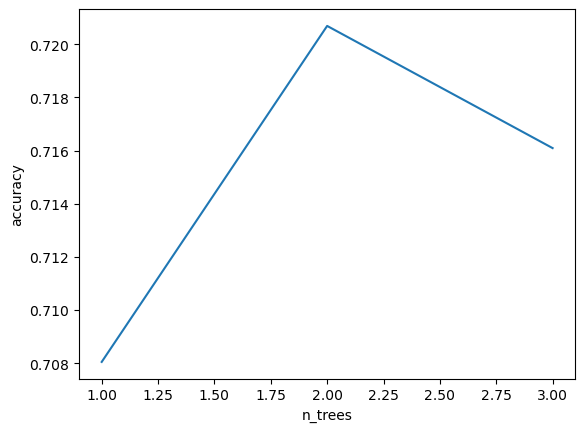

In [48]:
#FIND THE BEST NUMBER OF TREES BETWEEN 30,40,50,60,70,80,90,100 WITH N_SELECTED_FEATURES between 'best',6,8, create a plot e return the model with highest accuracy:

def find_best_n_trees(space_titanic_df_train, space_titanic_df_val, n_trees_list, sample_ratio, n_selected_features):
    #TO-DO
    accuracies = []
    models = []
    
    for n_trees in n_trees_list:
        r_f = RandomForest(decision_tree_type=d_t, n_trees=n_trees)
        r_f = r_f.build_forest(space_titanic_df_train, 
                                sample_ratio =sample_ratio, 
                                n_selected_features=n_selected_features)
        predictions = r_f.get_model_accuracy(space_titanic_df_val.columns[:-1],space_titanic_df_val)
        accuracies.append(accuracy_score(space_titanic_df_val.iloc[:,-1].values,predictions))
        models.append(r_f)
        
    plt.plot(n_trees_list,accuracies)
    plt.xlabel('n_trees')
    plt.ylabel('accuracy')
    plt.show()
    
    return models[accuracies.index(max(accuracies))]

best_model = find_best_n_trees(space_titanic_df_train, space_titanic_df_val, [1,2,3], .9, 'best')

In [49]:
best_model

In [50]:
'''GET MODEL ACCURACY ON VALIDATION DATA'''
predictions_validation = r_f.get_model_accuracy(space_titanic_df_val.columns.values.tolist(), space_titanic_df_val)  

TypeError: 'NoneType' object is not iterable

In [ ]:
labels = space_titanic_df_val.iloc[:,-1].values
acc = [1 if x == y else 0  for x, y in zip(labels, predictions_validation)]
acc_tot = sum(acc)/len(labels) * 100
print("Accuratezza modello del {}".format(acc_tot))

In [ ]:
predictions = []
for i,row in enumerate(space_titanic_df_val.values):            
    pred = r_f.classify_forest(space_titanic_df_val.columns.values.tolist(),row)
    predictions.append(pred)

In [51]:
space_titanic_df_val['pred'] = space_titanic_df_val.apply(lambda x: best_model.classify_forest(space_titanic_df_val.columns.values.tolist(),x),axis=1)

In [52]:
space_titanic_df_val

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,pred
PassengerId,,,,,,,,,,,,
0337_02,Mars,False,TRAPPIST-1e,19.0,False,417.0,349.0,634.0,3.0,1057.0,True,False
2891_01,Earth,False,TRAPPIST-1e,18.0,False,4.0,904.0,0.0,0.0,1.0,False,False
8998_01,Earth,True,TRAPPIST-1e,41.0,True,0.0,0.0,0.0,0.0,0.0,False,True
1771_01,Earth,False,TRAPPIST-1e,35.0,False,0.0,338.0,436.0,0.0,0.0,True,False
9034_02,Europa,True,TRAPPIST-1e,43.0,True,0.0,0.0,0.0,0.0,0.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
6671_03,Mars,False,55 Cancri e,14.0,False,1880.0,0.0,15.0,0.0,0.0,False,False
5367_01,Europa,True,TRAPPIST-1e,4.0,True,0.0,0.0,0.0,0.0,0.0,True,True
6167_01,Earth,True,PSO J318.5-22,42.0,True,0.0,0.0,0.0,0.0,0.0,True,True


In [ ]:
#space_titanic_df_test['Transported'] = 
space_titanic_df_test.apply(lambda x: r_f.classify_forest(space_titanic_df_test.columns.values.tolist(),x),axis=1)


In [ ]:
submission = space_titanic_df_test.reset_index()[['PassengerId','Transported']]
submission = submission.set_index('PassengerId')
submission